# Video Search




## Step 1:  Video library (10 points)

Write a python API  that will download the video and its closed captions from youtube. Make sure to document how one can use your API. Use this to download the following videos from youtube along with thei captions:

https://www.youtube.com/watch?v=wbWRWeVe1XE

https://www.youtube.com/watch?v=FlJoBhLnqko

https://www.youtube.com/watch?v=Y-bVwPRy_no

In [24]:
from pytube import YouTube
YouTube('https://www.youtube.com/watch?v=wbWRWeVe1XE').streams.first().download()

'/home/jovyan/CS370-Assignments/What Does High-Quality Preschool Look Like  NPR Ed.mp4'

## Step 2: Video indexing pipeline (90 points)

In this step you will build and train your models to extract embeddings for the frames of your videos and store the extracted information in a database such as postgres for indexing the videos.

### 2.1 Preprocess the video (15 points)

You can use opencv, ffmpeg, gstreameer, https://pytorchvideo.org/ or any other library to implement the preprocessing steps as shown below:
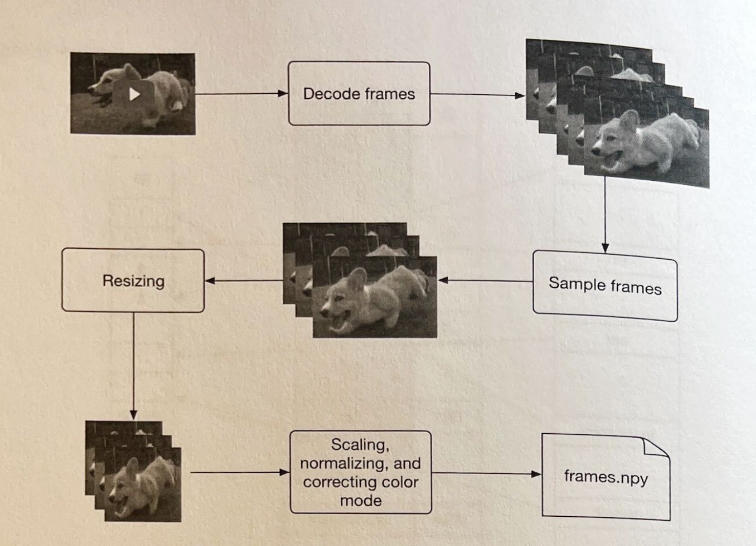



In [25]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

import IPython.display as ipd
from tqdm.notebook import tqdm

import subprocess

In [26]:
input_file = 'What Does High-Quality Preschool Look Like  NPR Ed.mp4'
subprocess.run(['ffmpeg', '-i', input_file, 
                '-qscale', '0',
                '-loglevel', 'quiet',
                'output.mp4'])

CompletedProcess(args=['ffmpeg', '-i', 'What Does High-Quality Preschool Look Like  NPR Ed.mp4', '-qscale', '0', '-loglevel', 'quiet', 'output.mp4'], returncode=0)

# Watch the video

In [27]:
ipd.Video('output.mp4')

# Open The video and read the metadata

In [28]:
# Load in video capture
cap = cv2.VideoCapture('output.mp4')

In [29]:
# Total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [30]:
# Total number of frames in the video
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print(f'Height: {height}, Width: {width}, Total Frames: {total_frames}')

Height: 360, Width: 640, Total Frames: 8204


In [31]:
# Frames per second
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'Frames per second: {fps:0.2f}')

Frames per second: 23.98


In [32]:
cap.release()

# Pulling in images from Video

In [33]:
cap = cv2.VideoCapture('output.mp4')

In [34]:
ret, img = cap.read()
print(f'Returned: {ret}, Image Shape: {img.shape}')

Returned: True, Image Shape: (360, 640, 3)


In [35]:
## Helper function for plotting opencv images in notebook
def display_cv2_img(img, cmap=None, size=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=size)
    ax.imshow(img_)
    ax.axis('off')

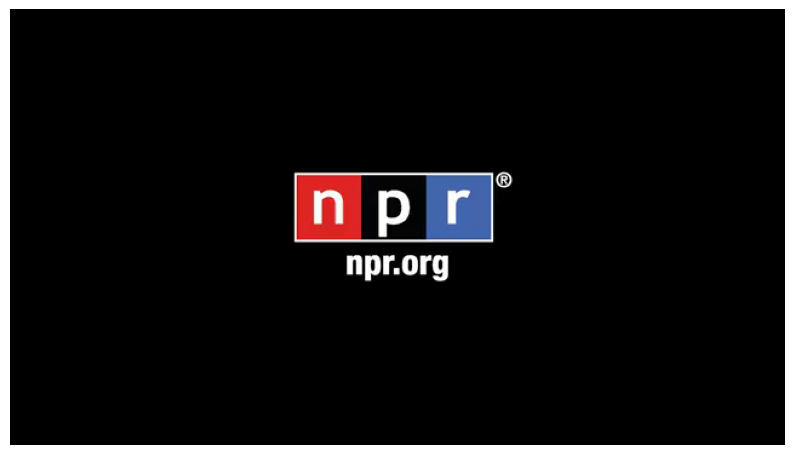

In [36]:
display_cv2_img(img)

In [37]:
cap.release()

# Display multiple frames from the video

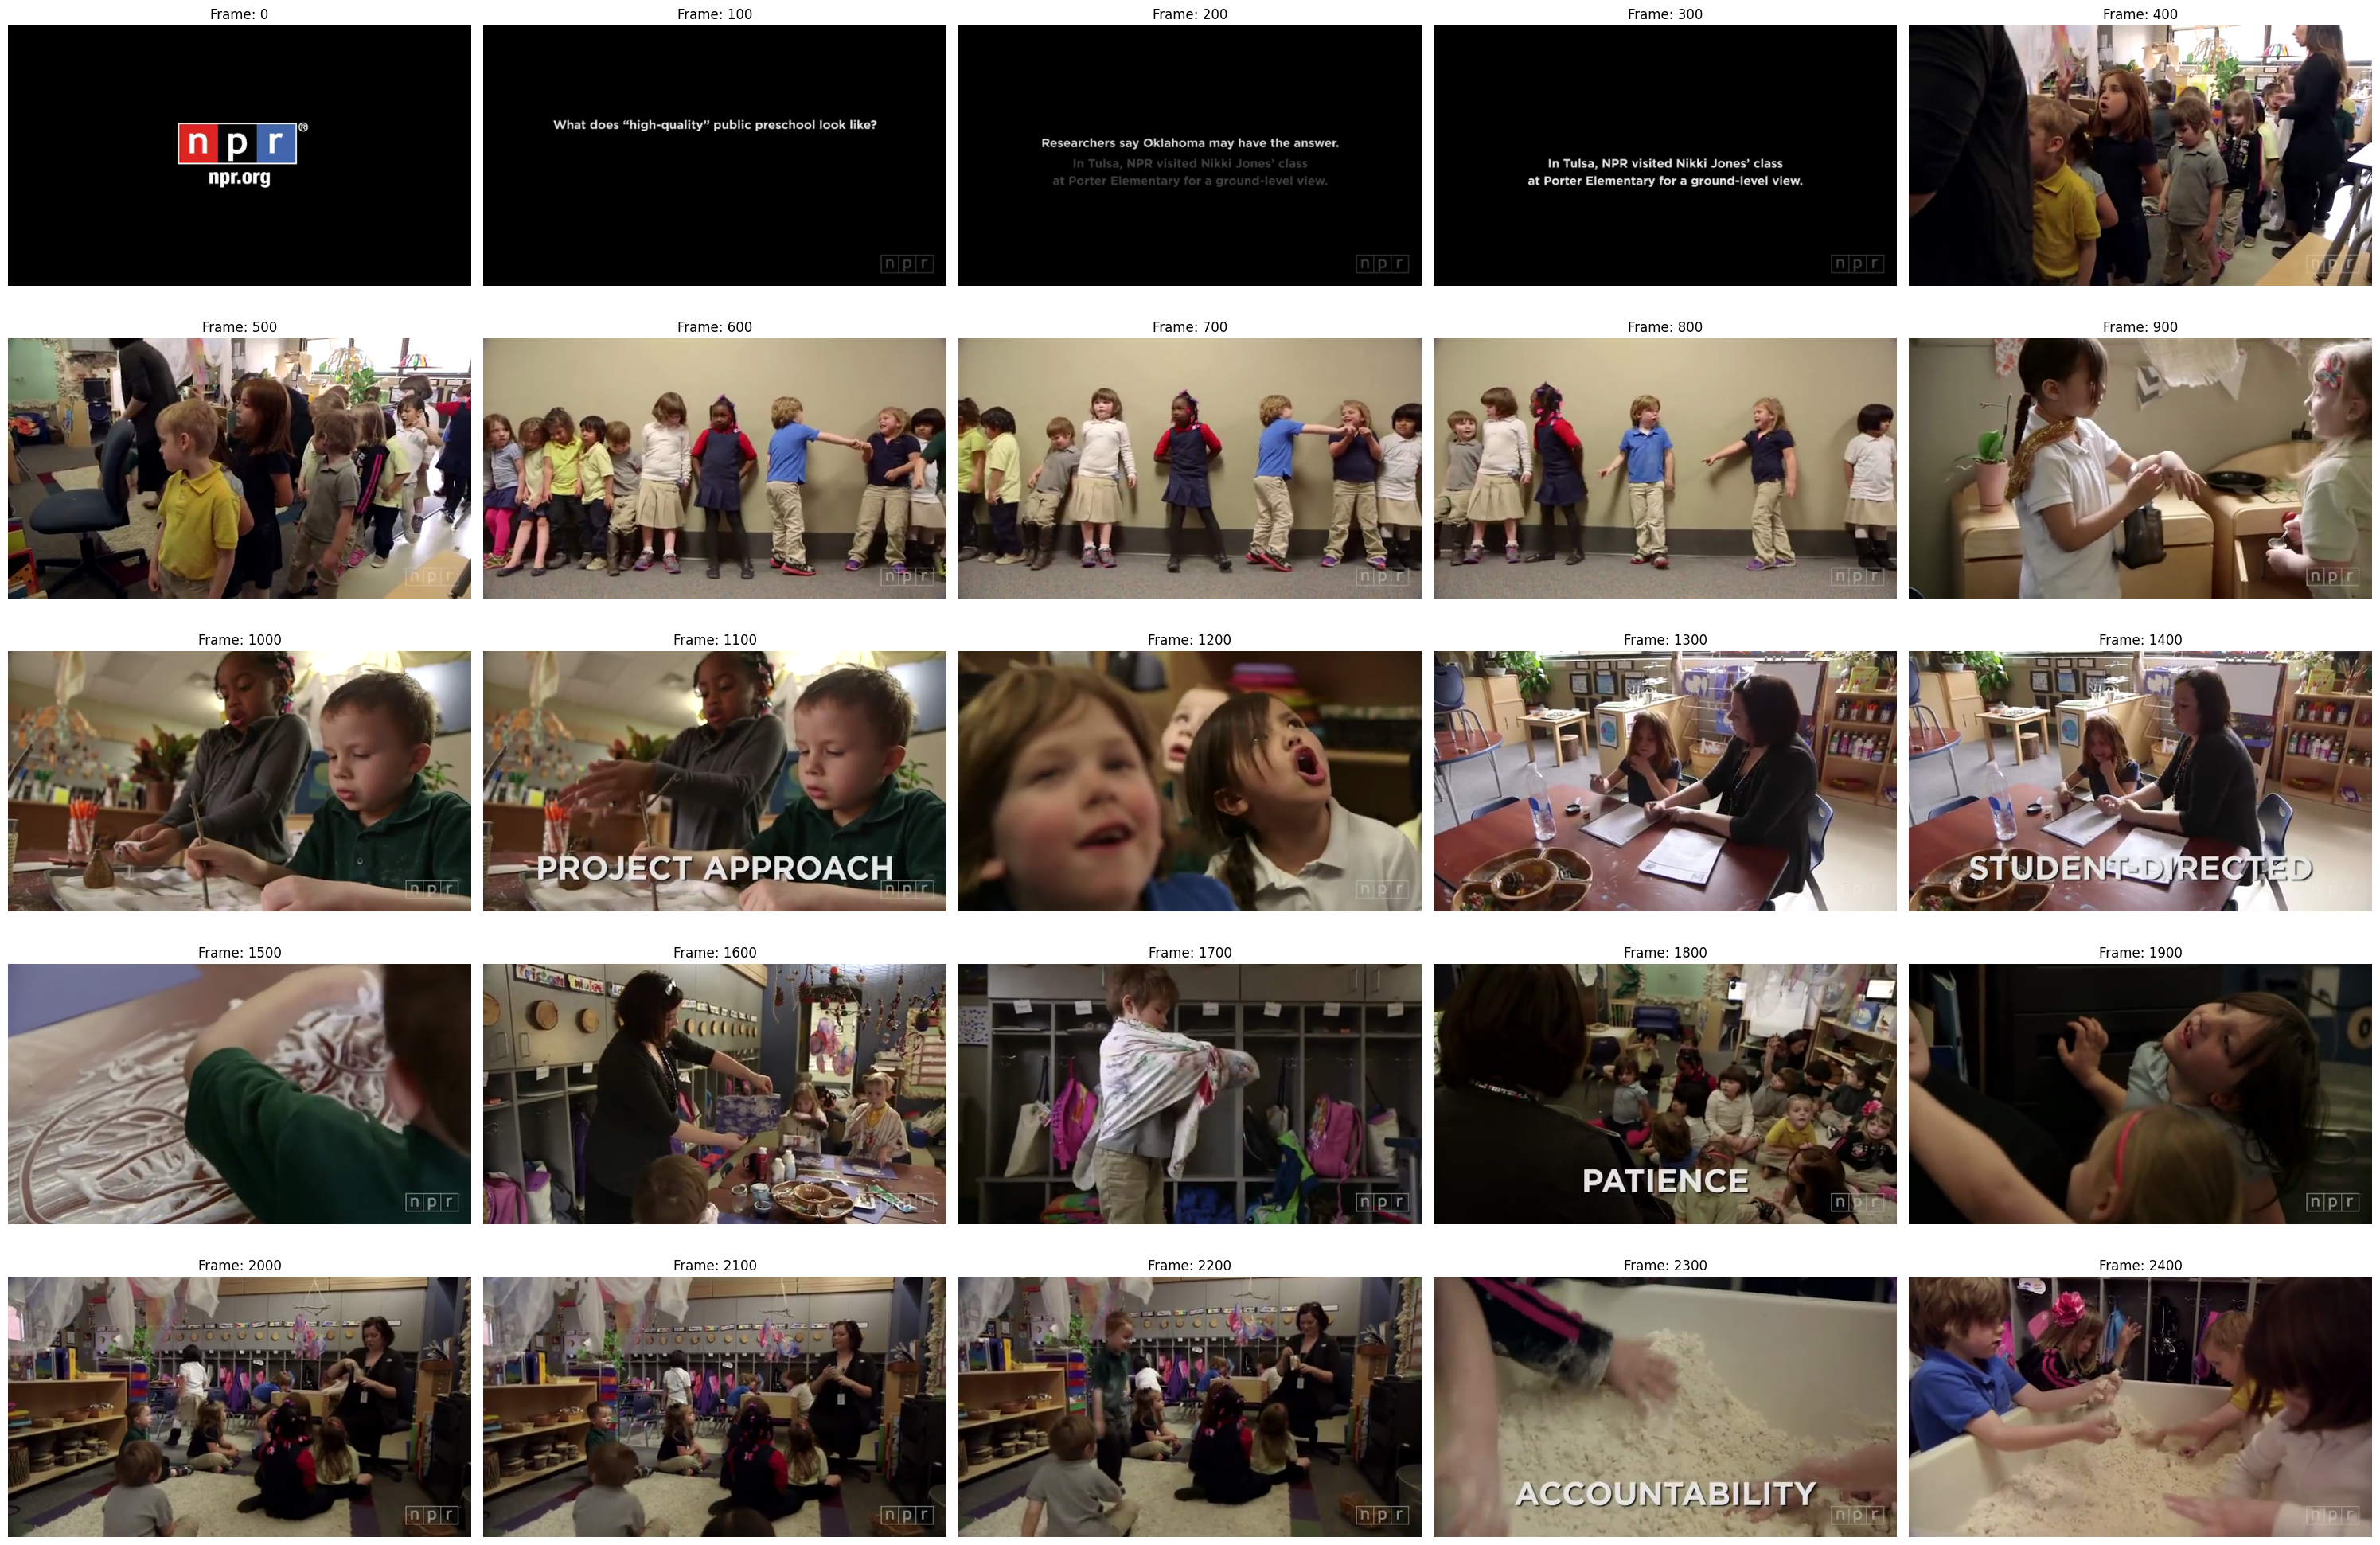

In [50]:
fig, ax = plt.subplots(5, 5, figsize=(30, 20))
ax = ax.flatten()

cap = cv2.VideoCapture('output.mp4')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame in range(n_frames):
    ret, img = cap.read()
    if not ret or img_idx >= 25:
        break
    if frame % 100 == 0:
        ax[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[img_idx].set_title(f'Frame: {frame}')
        ax[img_idx].axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()
cap.release()

### 2.2 Detecting objects (25 points)

Use any of the pretrained object-detectors to detect objects belonging to MS COCO classes.
For each video, for each frame where a detection is found, compile and report the results in the following tabular structure :

[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]

Feel free to finetune your detectors if required. If you notice that your model performs better on a different video from this [channel](https://www.youtube.com/@NPR), document this and you can use this video for the rest of this assignment.

### 2.3 Embedding model (30 points)

Develop a convolutional autoencoder such as [the one described here](https://blog.keras.io/building-autoencoders-in-keras.html) whose input will be all the objects detected in each frame (not the entire frame!), if any.
Note : You can downsample the frame rate of your original video to avoid long training/processing times. For a given input image, the autoencoder should output it's small vector embedding.

Train your autoencoder on the COCO dataset for classes which get detected in the given list of videos.

#### Extra credit (10 points)
Extra credit: if you want to maximize the possibility of developing something **new** think about how a video can be better segmented into representative frames. For example, [in this ~3min video accessed Nov 2023](https://youtu.be/FN8a8mZNik8?si=wXdbOGuLGkGsWsf) you have multiple scenes each one lasting 30sec or so. Can you find a way to segment each video and store the frame embeddings of each segment? This way there are multiple embeddings per video and you need to keep them that way for the subsequesnt steps of this project.

### Indexing the embeddings (20 points)

Use `docker compose` to bring up two docker containers, your application container with the dev environment (you must have done this in Step 1) and a second container with postgres.

`docker pull postgres:latest`

Process all the detected object sub-images for each frame of each video to compile your final results in the following tabular structure:
[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info, vector<embedding of this object>, optional<sceneId from extra credit>]

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension) you can use [this guide](https://dev.to/sfoteini/image-vector-similarity-search-with-azure-computer-vision-and-postgresql-12f7).

Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.
